## Import Necessary Libraries

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import matplotlib.pyplot as plt
from keras.models import load_model
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
%matplotlib inline


In [2]:
print(tf.__version__)
print(keras.__version__)
print(np.__version__)

2.10.1
2.10.0
1.26.4


## Load the dataset & Preprocessing

In [3]:
train_path='preprocessed_data\\train'
valid_path='preprocessed_data\\valid'
test_path='preprocessed_data\\test'

In [4]:
train_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(train_path,target_size=(224,224),batch_size=20)
valid_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(valid_path,target_size=(224,224),batch_size=20)
test_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test_path,target_size=(224,224),batch_size=20,shuffle=False)

Found 397 images belonging to 2 classes.
Found 64 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


## Define & Customize pre-trained MobileNet model 

In [5]:
mobile1=keras.applications.mobilenet.MobileNet()

In [6]:
mobile1.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [7]:
mobile1.output_shape

(None, 1000)

#### Build a new model that consist of the original MobileNet up to the fifth to last layer

In [8]:
x = mobile1.layers[-5].output

#### reshape output.shape from last layer and add output layer

In [9]:
x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
predictions=Dense(2,activation='sigmoid')(x)
model=Model(inputs=mobile1.input,outputs=predictions)

In [10]:
model.output_shape

(None, 2)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

#### freezing the weights

In [12]:
for layer in model.layers[:-2]:
    layer.trainable = False

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

## Train The Model

### compile the model

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

#### add early stopping callback

In [15]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode="min",
    patience=5, 
    restore_best_weights=True
)

#### fit the model

In [16]:
len(train_batches)

20

In [17]:
len(valid_batches)

4

In [18]:
history = model.fit_generator(train_batches,steps_per_epoch=len(train_batches),validation_data=valid_batches,validation_steps=len(valid_batches),epochs=10,verbose=2, callbacks=[early_stopping])

C:\Users\Hashan\AppData\Local\Temp\ipykernel_11576\3494267884.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_batches,steps_per_epoch=len(train_batches),validation_data=valid_batches,validation_steps=len(valid_batches),epochs=10,verbose=2, callbacks=[early_stopping])


Epoch 1/10


c:\Users\Hashan\anaconda3\envs\Dilshi_Research\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


20/20 - 31s - loss: 0.7797 - accuracy: 0.4433 - val_loss: 0.7585 - val_accuracy: 0.4375 - 31s/epoch - 2s/step
Epoch 2/10
20/20 - 24s - loss: 0.7453 - accuracy: 0.4836 - val_loss: 0.7405 - val_accuracy: 0.4375 - 24s/epoch - 1s/step
Epoch 3/10
20/20 - 23s - loss: 0.7258 - accuracy: 0.4912 - val_loss: 0.7209 - val_accuracy: 0.4688 - 23s/epoch - 1s/step
Epoch 4/10
20/20 - 22s - loss: 0.7065 - accuracy: 0.5340 - val_loss: 0.7072 - val_accuracy: 0.5000 - 22s/epoch - 1s/step
Epoch 5/10
20/20 - 22s - loss: 0.6893 - accuracy: 0.5642 - val_loss: 0.6916 - val_accuracy: 0.5625 - 22s/epoch - 1s/step
Epoch 6/10
20/20 - 22s - loss: 0.6736 - accuracy: 0.6146 - val_loss: 0.6816 - val_accuracy: 0.6250 - 22s/epoch - 1s/step
Epoch 7/10
20/20 - 30s - loss: 0.6582 - accuracy: 0.6322 - val_loss: 0.6667 - val_accuracy: 0.5625 - 30s/epoch - 2s/step
Epoch 8/10
20/20 - 23s - loss: 0.6439 - accuracy: 0.6725 - val_loss: 0.6571 - val_accuracy: 0.6719 - 23s/epoch - 1s/step
Epoch 9/10
20/20 - 22s - loss: 0.6311 - acc

#### test accuracy

In [19]:
loss, acc = model.evaluate(test_batches)

2/2 [==============================] - 3s 967ms/step - loss: 0.6227 - accuracy: 0.6250


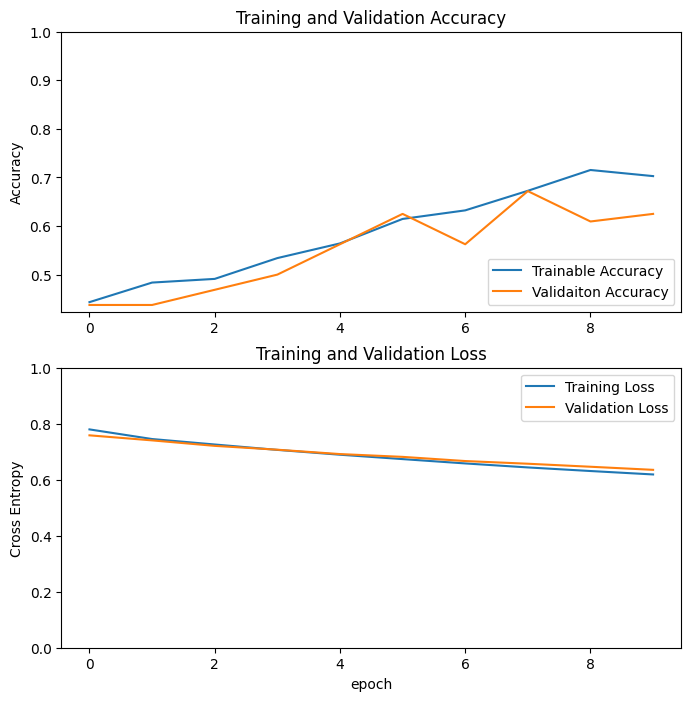

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Trainable Accuracy')
plt.plot(val_acc, label='Validaiton Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

In [21]:
# Setting the top layer as trainable
mobile1.trainable = True

In [22]:
ft_model = mobile1.layers[-5].output
ft_model = tf.keras.layers.Reshape(target_shape=(1024,))(ft_model)
predictions=Dense(2,activation='sigmoid')(ft_model)
ft_model=Model(inputs=mobile1.input,outputs=predictions)

In [23]:
print('Number of layers in the base model: ', len(ft_model.layers))

Number of layers in the base model:  89


In [24]:
# Fine-tune from this layer onwards 
fine_tune_at = 60


# Freeze all the layers before the `fine_tune_at` layer
for layer in ft_model.layers[:fine_tune_at]:
    layer.trainable = False

In [25]:
ft_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

c:\Users\Hashan\anaconda3\envs\Dilshi_Research\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [26]:
ft_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [27]:
# Printing the no. of trainable_variables of the model
len(model.trainable_variables)

26

#### Continue training the model

In [28]:
history_fine   = ft_model.fit_generator(train_batches,steps_per_epoch=len(train_batches), validation_data=valid_batches,validation_steps=len(valid_batches), epochs=20, initial_epoch=history.epoch[-1], verbose=2, callbacks=[early_stopping])

C:\Users\Hashan\AppData\Local\Temp\ipykernel_11576\3921286146.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_fine   = ft_model.fit_generator(train_batches,steps_per_epoch=len(train_batches), validation_data=valid_batches,validation_steps=len(valid_batches), epochs=20, initial_epoch=history.epoch[-1], verbose=2, callbacks=[early_stopping])


Epoch 10/20
20/20 - 45s - loss: 0.3194 - accuracy: 0.9018 - val_loss: 1.3546 - val_accuracy: 0.7812 - 45s/epoch - 2s/step
Epoch 11/20
20/20 - 37s - loss: 0.1334 - accuracy: 0.9622 - val_loss: 0.2058 - val_accuracy: 0.9531 - 37s/epoch - 2s/step
Epoch 12/20
20/20 - 36s - loss: 0.0279 - accuracy: 0.9849 - val_loss: 0.2265 - val_accuracy: 0.9531 - 36s/epoch - 2s/step
Epoch 13/20
20/20 - 35s - loss: 0.0476 - accuracy: 0.9874 - val_loss: 0.7997 - val_accuracy: 0.8906 - 35s/epoch - 2s/step
Epoch 14/20
20/20 - 34s - loss: 0.0569 - accuracy: 0.9798 - val_loss: 0.4347 - val_accuracy: 0.9062 - 34s/epoch - 2s/step
Epoch 15/20
20/20 - 39s - loss: 0.0190 - accuracy: 0.9924 - val_loss: 0.3692 - val_accuracy: 0.8750 - 39s/epoch - 2s/step
Epoch 16/20
20/20 - 42s - loss: 0.0204 - accuracy: 0.9950 - val_loss: 1.0348 - val_accuracy: 0.7969 - 42s/epoch - 2s/step


In [29]:
ft_model.evaluate(test_batches)

2/2 [==============================] - 3s 961ms/step - loss: 0.2501 - accuracy: 0.9000


[0.25007525086402893, 0.8999999761581421]

In [30]:
# acc_ft= history_fine.history['accuracy']
# val_acc_ft= history_fine.history['val_accuracy']

# loss_ft= history_fine.history['loss']
# val_loss_ft= history_fine.history['val_loss']

# plt.figure(figsize=(8,8))
# plt.subplot(2,1,1)
# plt.plot(acc_ft, label='Trainable Accuracy')
# plt.plot(val_acc_ft, label='Validaiton Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([0.4, 1.1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss_ft, label='Training Loss')
# plt.plot(val_loss_ft, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0, 1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

# loss += history_fine.history['loss']
# val_loss += history_fine.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

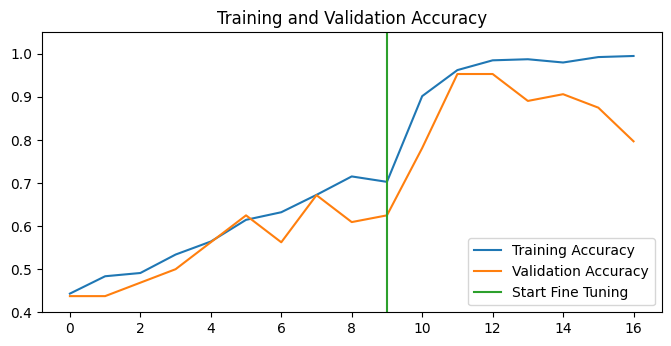

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1.05])
plt.plot([10-1,10-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

## Save the fine tune model

In [ ]:
# ft_model.save("model.h5")

# Model evaluation

#### show test images

In [34]:
def plotImages(images_arr, labels_arr, class_names=None):
    fig, axes = plt.subplots(8, 5, figsize=(20,20))
    axes = axes.flatten()

    for img, label, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')

        # If class_names are provided, display the corresponding label as text
        if class_names is not None:
            label_name = class_names[np.argmax(label)]  # Get the class name based on the one-hot encoded label
            ax.set_title(label_name, fontsize=10, color='red')
        else:
            ax.set_title(f"Label: {label}", fontsize=10, color='red')

    plt.tight_layout()
    plt.show()

In [35]:
test_batches

In [36]:
all_images = []
all_labels = []

# Loop through the generator to extract all batches
for i in range(test_batches.n // test_batches.batch_size + 1):  # Loop through all batches
    images, labels = next(test_batches)  # Get the next batch
    all_images.append(images)
    all_labels.append(labels)

# Combine all batches into single arrays
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [37]:
len(all_labels)

60

In [38]:
clz_name=['Attention','Not_Attention']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

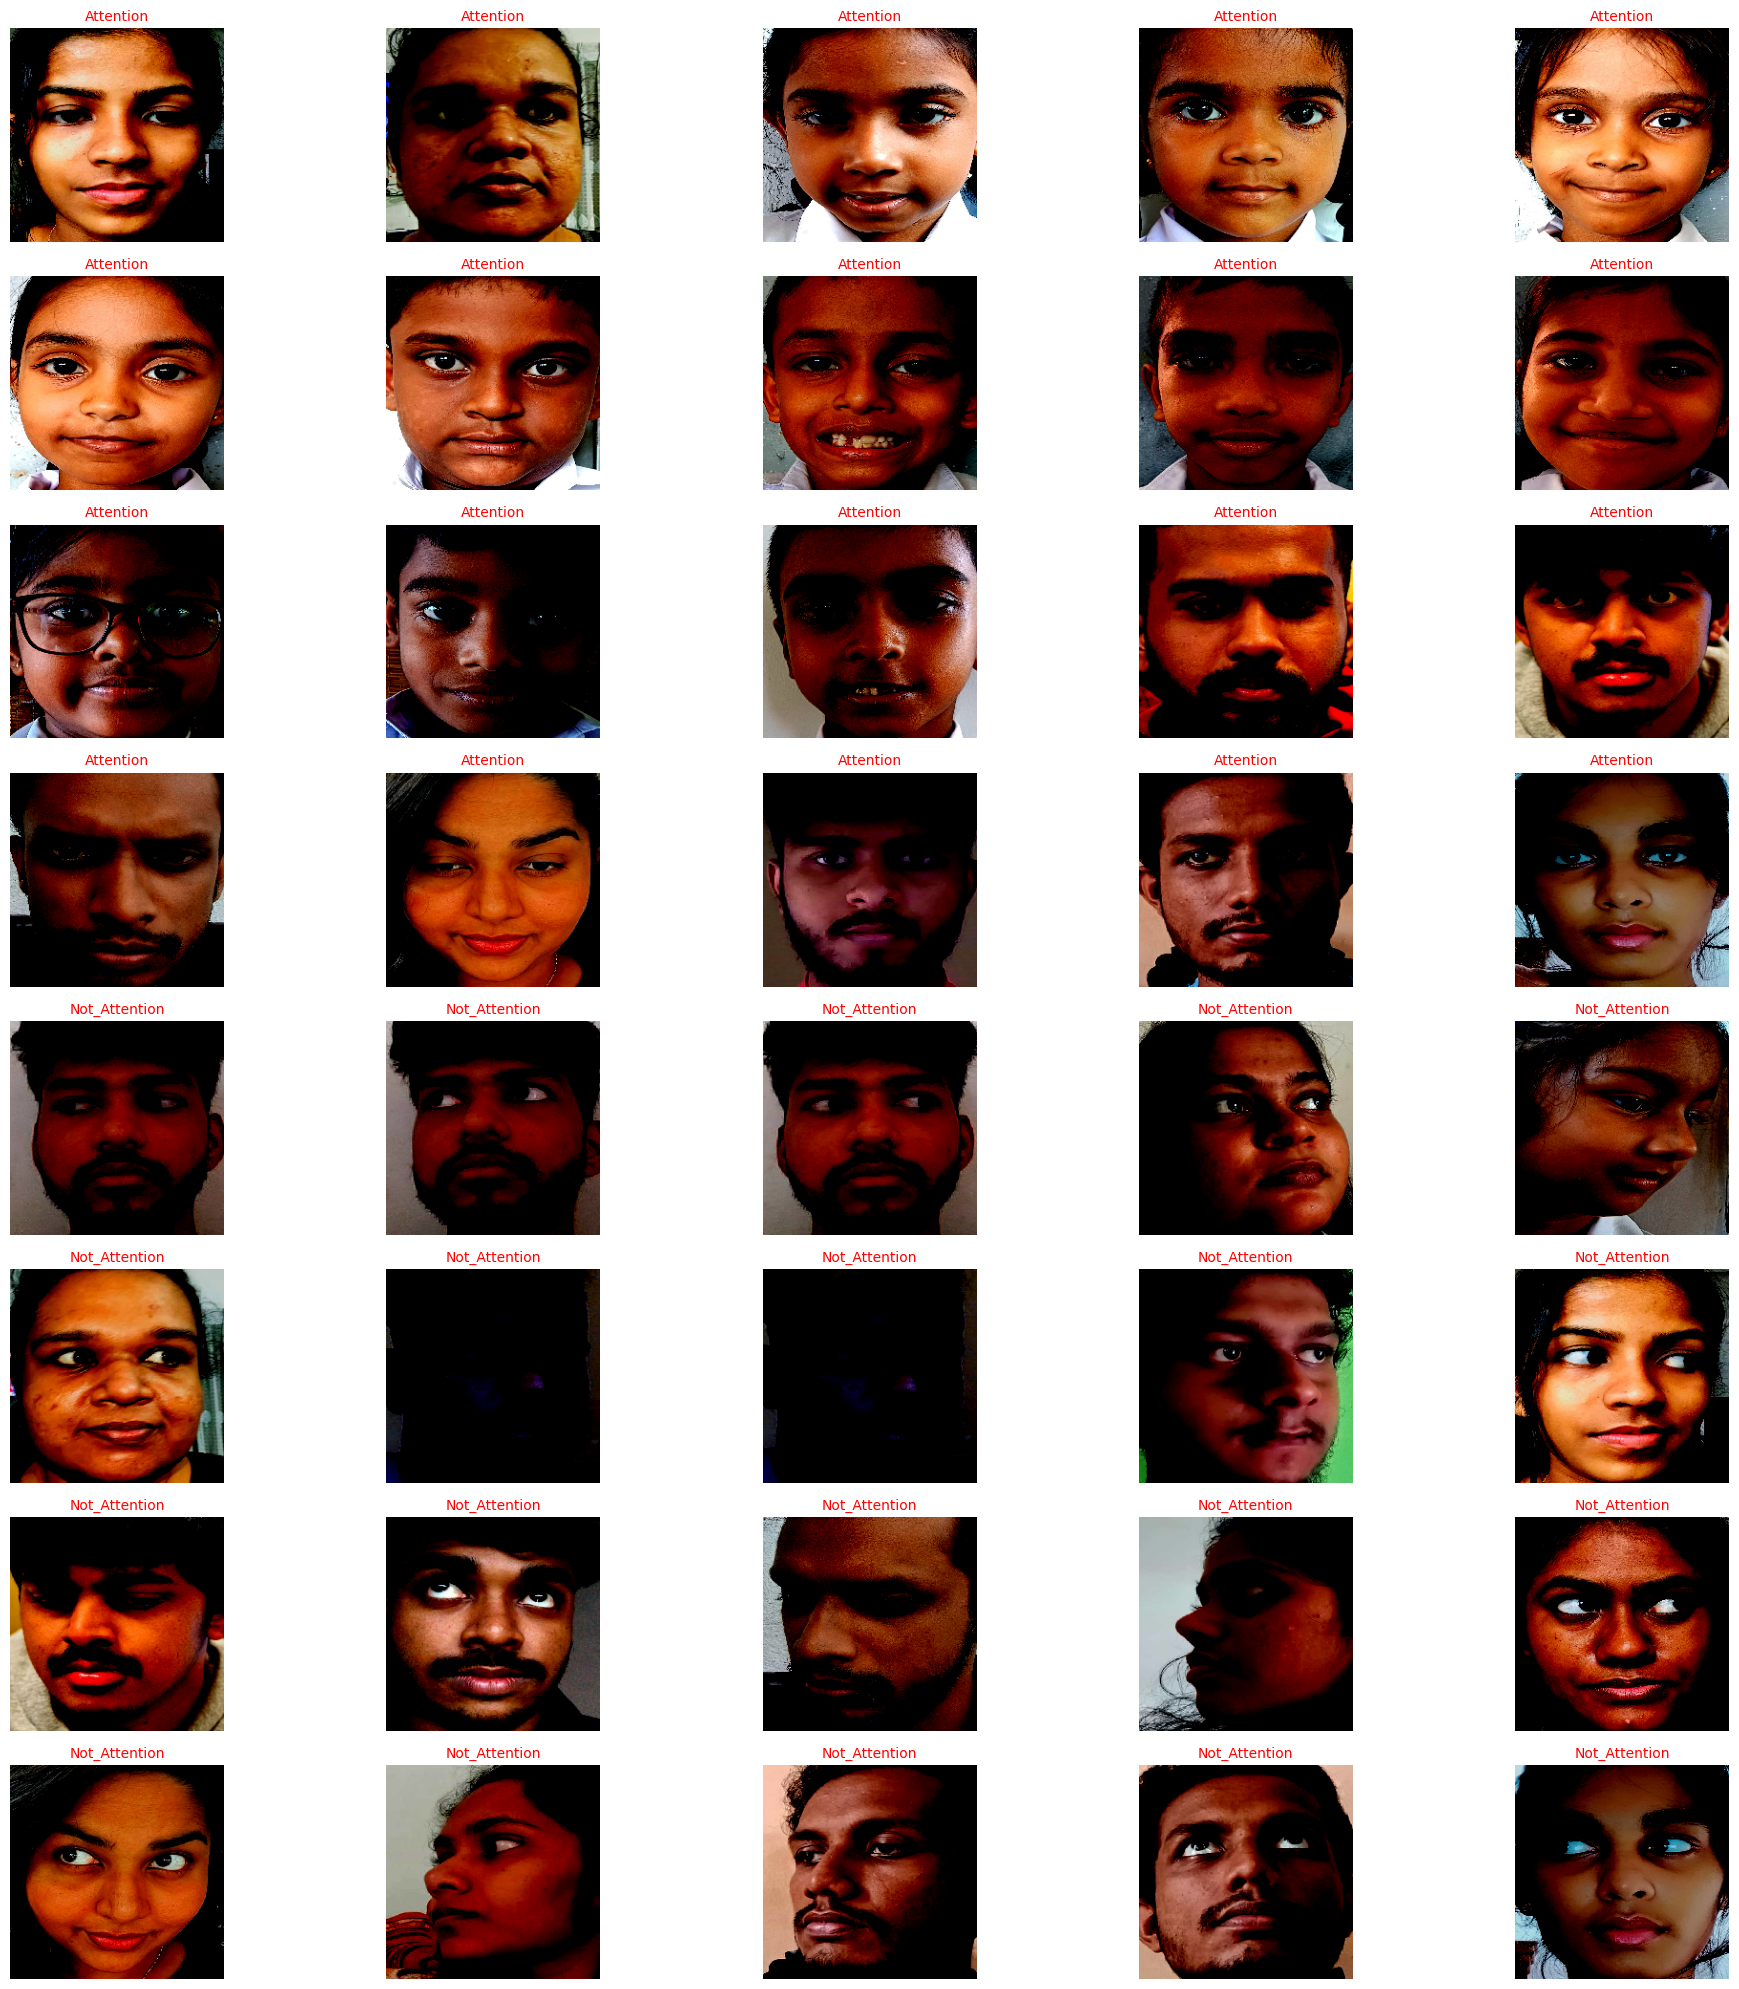

In [39]:
# test_imgs,test_labels=next(test_batches)
plotImages(all_images, all_labels, clz_name)
# print(all_labels)

#### predict the classes of test images

In [40]:
test_batches.class_indices

{'attention': 0, 'not attention': 1}

In [41]:
predictions=ft_model.predict(x=test_batches,verbose=0)
np.argmax(predictions,axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

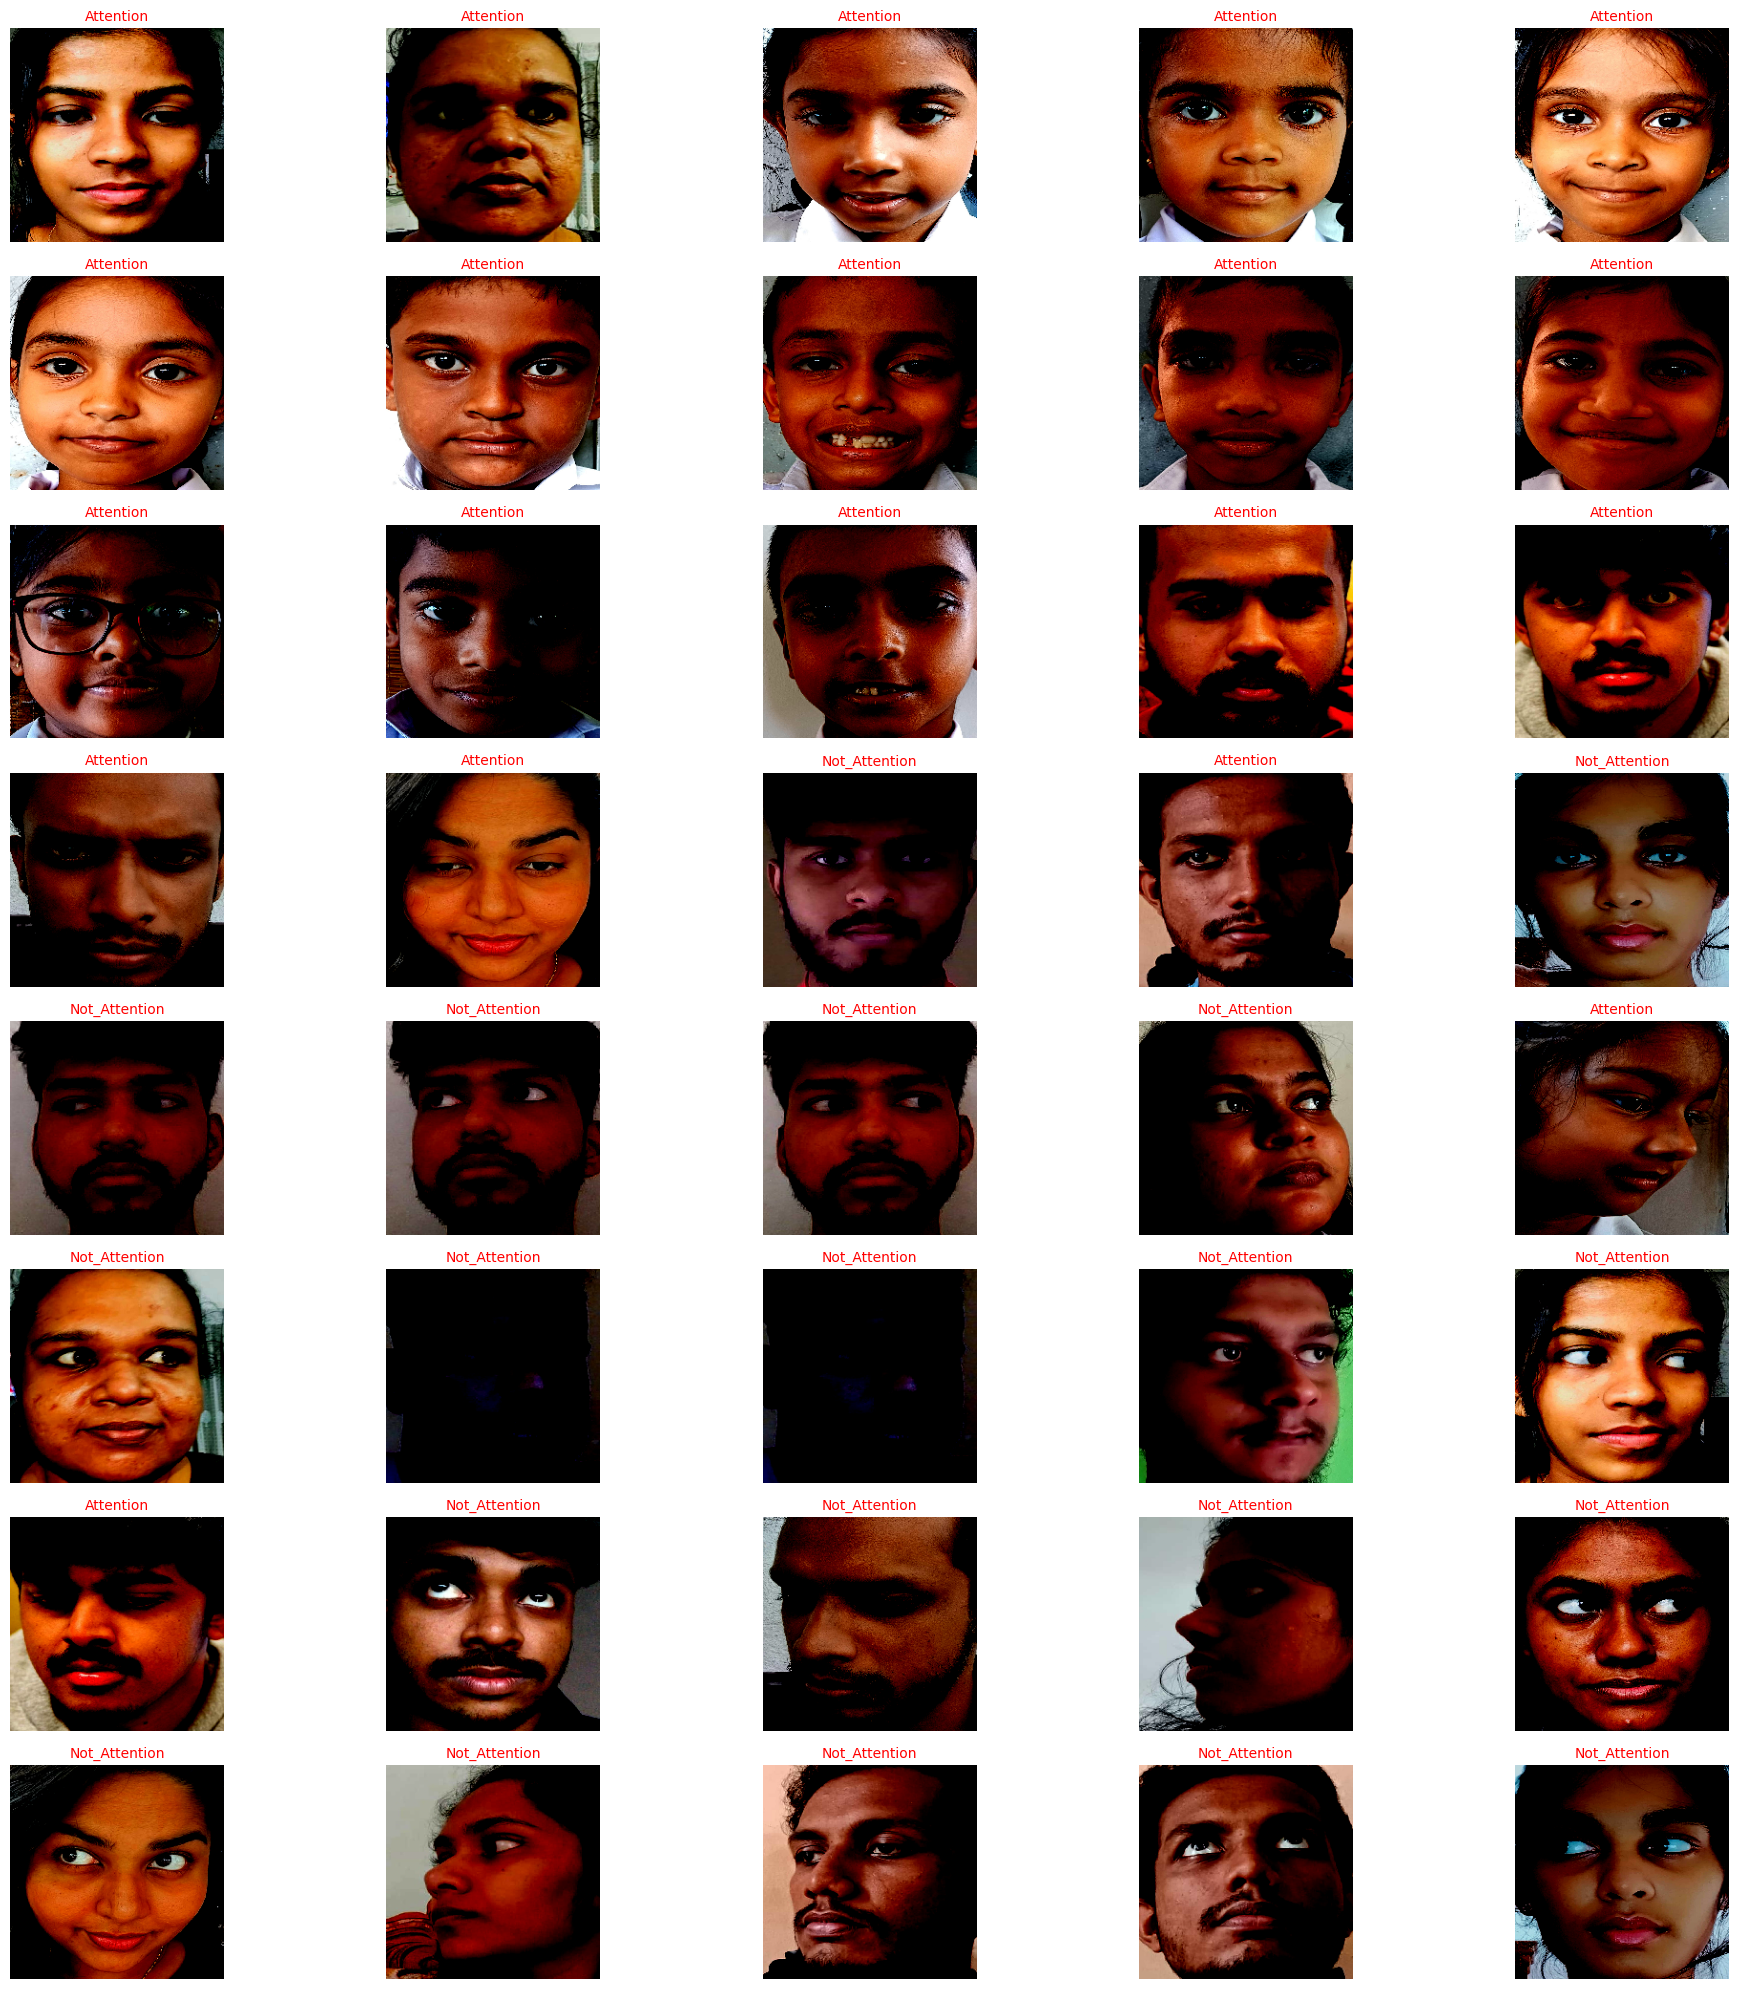

In [42]:
plotImages(all_images, predictions, clz_name)

### confusion_matrix

In [43]:
cm=confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=-1))

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[18  2]
 [ 2 18]]


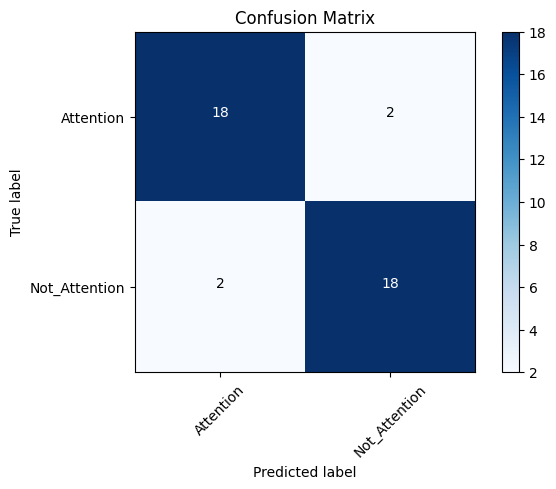

In [45]:
cm_plot_labels=['Attention','Not_Attention']

plt.figure()
plot_confusion_matrix(cm,cm_plot_labels,title='Confusion Matrix')

In [50]:

report = classification_report(test_batches.classes, np.argmax(predictions,axis=-1), target_names=test_batches.class_indices.keys())
print(report)


               precision    recall  f1-score   support

    attention       0.90      0.90      0.90        20
not attention       0.90      0.90      0.90        20

     accuracy                           0.90        40
    macro avg       0.90      0.90      0.90        40
 weighted avg       0.90      0.90      0.90        40

